In [12]:
# Import resources
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
import sys

# Access project directory 
base_dir = './'
sys.path.append(base_dir)

# Paths
dataset_dir = os.path.join(base_dir, 'dataset')
model_dir = os.path.join(base_dir, 'model')

In [14]:
from data.dataset import get_dataset_dict
 
# Load datasets
dataset_dict = get_dataset_dict(dataset_dir)

In [15]:
from data.model_class.DataPipelineParams import Augmentation, Dataset
 
## PARAMETERS
AUGMENTATION = Augmentation.HIGH
CROSS_ENTROPY = True
DATASET = Dataset.FERPLUS
N_CLASSES = 8
ORIGINAL_PREPROCESSING = True

# Model file name
MODEL_NAME = 'ferplus_model_pd'

In [16]:
## HYPERPARAMETERS
BATCH_SIZE = 128
EPOCHS = 1
DROPOUT_RATE = 0.10
LEARNING_RATE = 0.005
LEAKY_RELU_SLOPE = 0.02
LR_PATIENCE = 20
PATIENCE = 30
REGULARIZATION_RATE = 0.01

In [17]:
from data.data import get_data_pipeline
from data.model_class.DataPipelineParams import DataPipelineParams

# Data pipeline parameters
pipeline_params = DataPipelineParams(dataset = DATASET,
                                     cross_entropy = CROSS_ENTROPY,
                                     original_preprocessing = ORIGINAL_PREPROCESSING,
                                     batch_size = BATCH_SIZE,
                                     augmentation = AUGMENTATION)

pipeline_params_test = DataPipelineParams(dataset = DATASET,
                                          original_preprocessing = ORIGINAL_PREPROCESSING,
                                          batch_size = BATCH_SIZE,
                                          augmentation = AUGMENTATION)

# Data pipelines
training_pipeline = get_data_pipeline(dataset_df = dataset_dict['train'],
                                      params = pipeline_params,
                                      shuffle = True)
validation_pipeline = get_data_pipeline(dataset_dict['valid'],
                                        params = pipeline_params_test)
test_pipeline = get_data_pipeline(dataset_dict['test'],
                                  params = pipeline_params_test)

Number of elements: 27956
Number of elements: 3199
Number of elements: 3153


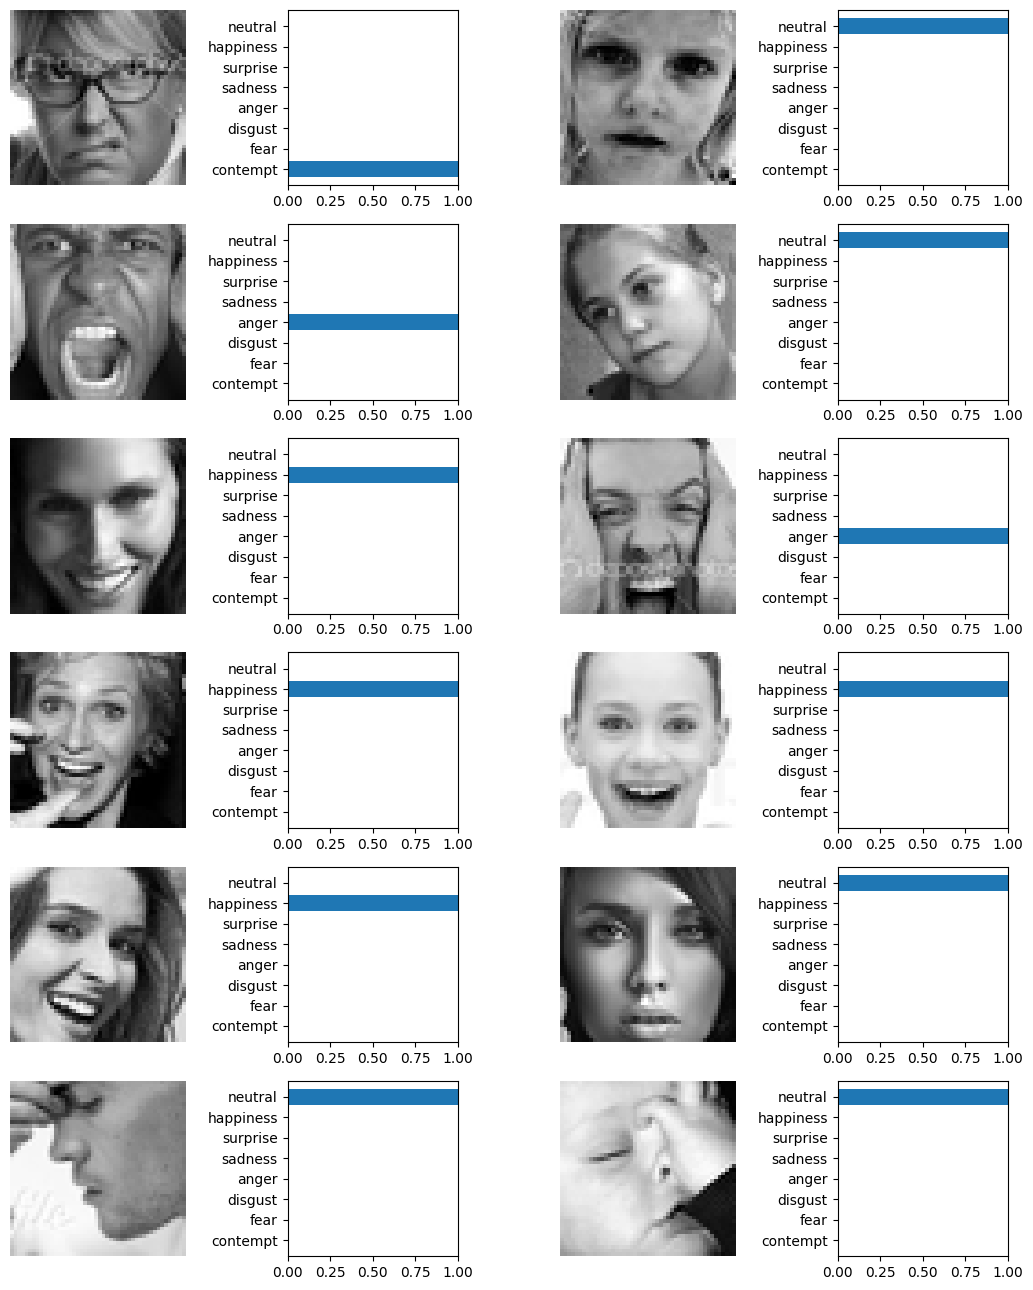

In [18]:
from data.data import get_fer_class_mapping, get_fer_plus_class_mapping
import predictions as ps

# Display sample images
image_batch, label_batch = test_pipeline.next()

if DATASET == Dataset.FER:
    class_mapping = get_fer_class_mapping()
else:
    class_mapping = get_fer_plus_class_mapping()

if CROSS_ENTROPY:
    ps.display_cross_entropy_predictions(image_batch, 
                                         label_batch, 
                                        class_mapping)
else:
    ps.display_majority_predictions(image_batch, 
                                    label_batch, 
                                    class_mapping)

In [19]:
import models

# Load model
model = models.get_performance_model(leaky_relu_slope = LEAKY_RELU_SLOPE,
                                     dropout_rate = DROPOUT_RATE,
                                     regularization_rate = REGULARIZATION_RATE,
                                     n_classes = N_CLASSES,
                                     logits = True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_10 (Separ  (None, 48, 48, 48)        105       
 ableConv2D)                                                     
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 48)        192       
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 48, 48, 48)        0         
                                                                 
 separable_conv2d_11 (Separ  (None, 48, 48, 48)        2784      
 ableConv2D)                                                     
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 48)        192       
 tchNormalization)                                    

In [20]:
from tensorflow import keras

# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits = True)

# Optimizer
model.compile(optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
              loss = loss,
              metrics = ['accuracy'])

In [21]:
# Training callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = PATIENCE,
    min_delta = 0.001
)

# Learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                              factor = 0.5,
                                              patience = LR_PATIENCE, 
                                              verbose = 1,
                                              min_delta = 0.001)

# Save the model with highest validation accuracy
model_file_path_acc = os.path.join(model_dir, MODEL_NAME + '_acc' + '.h5')
save_best_acc = keras.callbacks.ModelCheckpoint(model_file_path_acc,
                                                monitor = 'val_accuracy',
                                                save_best_only = True)
# Save also the model with lowest validation loss
model_file_path_loss = os.path.join(model_dir, MODEL_NAME + '_loss' + '.h5')
save_best_loss = keras.callbacks.ModelCheckpoint(model_file_path_loss,
                                                monitor = 'val_loss',
                                                save_best_only = True)

In [22]:
# Train
history = model.fit(
            training_pipeline,
            validation_data = validation_pipeline,
            epochs = EPOCHS,
            callbacks = [early_stopping, 
                         reduce_lr, 
                         save_best_acc, 
                         save_best_loss]
)

219/219 [==============================] - ETA: 0s - loss: 1.6330 - accuracy: 0.3603

c:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 118s 528ms/step - loss: 1.6330 - accuracy: 0.3603 - val_loss: 1.6160 - val_accuracy: 0.3695 - lr: 0.0050


In [23]:
import json
 
## Save training history
history_dict = history.history
for key in history_dict:
    for index in range(len(history_dict[key])):
        history_dict[key][index] = float(history_dict[key][index])

history_file_path = os.path.join(model_dir, MODEL_NAME + '.json')
 
# Save it under the form of a json file
with open(history_file_path, 'w') as file:
    json.dump(history_dict, file)

In [24]:
# Load training history
with open(history_file_path, 'r') as file:
    history = json.load(file)

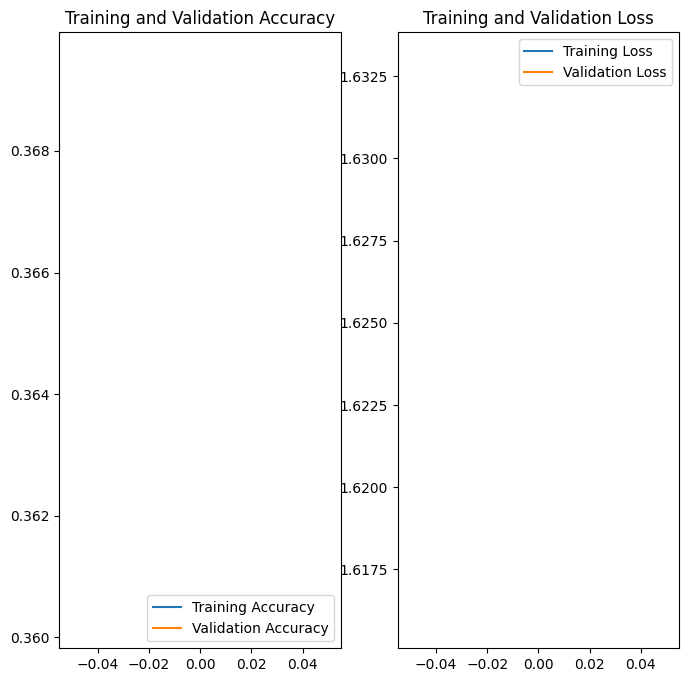

In [25]:
# Plot training history
ps.plot_training_history(history)

In [26]:
# Load best accuracy model
model.load_weights(model_file_path_acc)
 
# Evaluate
model.evaluate(training_pipeline)
model.evaluate(validation_pipeline)
model.evaluate(test_pipeline)

25/25 [==============================] - 4s 175ms/step - loss: 1.6345 - accuracy: 0.3457


[1.6344568729400635, 0.34570249915122986]

In [27]:
# Load best loss model
model.load_weights(model_file_path_loss)
 
# Evaluate
model.evaluate(training_pipeline)
model.evaluate(validation_pipeline)
model.evaluate(test_pipeline)

25/25 [==============================] - 5s 180ms/step - loss: 1.6345 - accuracy: 0.3457


[1.6344568729400635, 0.34570249915122986]

4/4 [==============================] - 0s 43ms/step


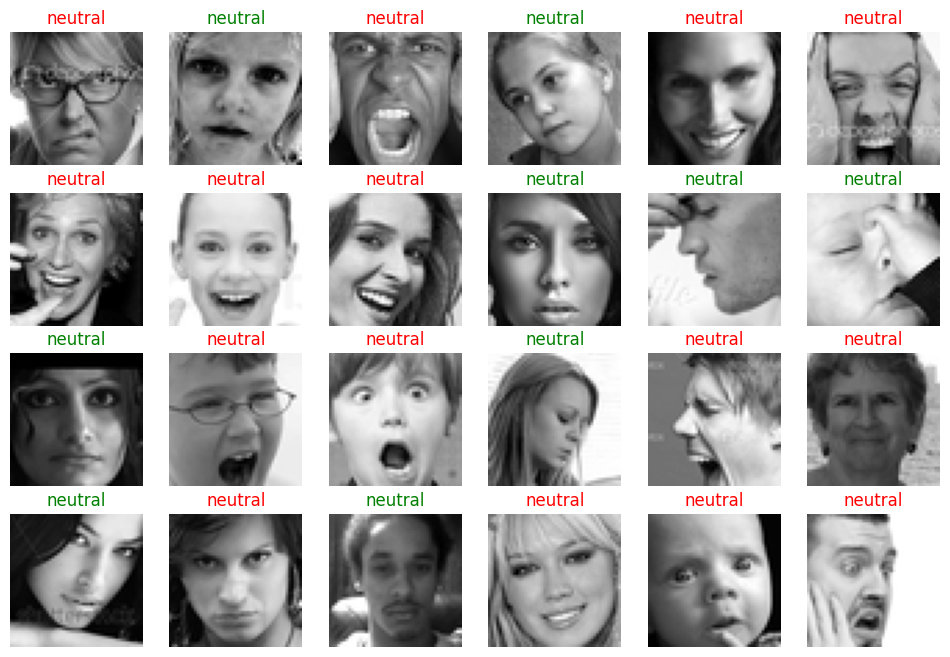

In [28]:
def softmax(x):
    '''Compute softmax values for each sets of scores in x.'''
    return np.exp(x) / np.sum(np.exp(x))

# Inference
label_predictions = model.predict(image_batch)
label_predictions = np.apply_along_axis(softmax, 1, label_predictions)

if DATASET == Dataset.FER:
    class_mapping = get_fer_class_mapping()
else:
    class_mapping = get_fer_plus_class_mapping()

ps.display_majority_predictions(image_batch, 
                                label_batch, 
                                class_mapping,
                                label_predictions)

25/25 [==============================] - 5s 199ms/step


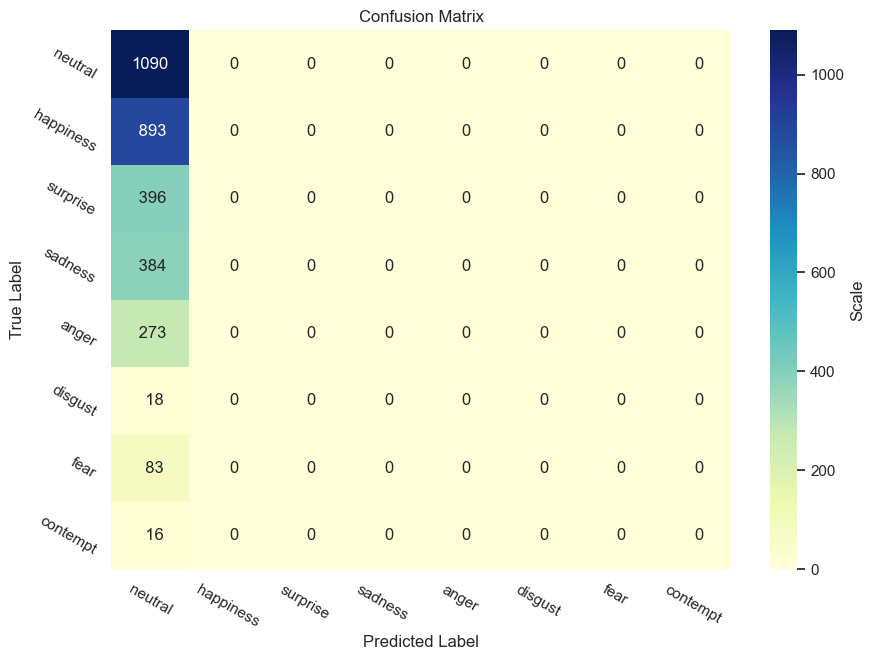

In [29]:
from data.data import get_labels
from tensorflow.math import confusion_matrix

# Get confusion matrix
y_pred = model.predict(test_pipeline, batch_size = BATCH_SIZE)
y_pred = softmax(y_pred)
y_pred = np.argmax(y_pred, axis = 1)
y_true = get_labels(dataset_dict['test'], params = pipeline_params_test)
y_true = np.argmax(y_true, axis = 1)
confusion_matrix = confusion_matrix(y_true, y_pred)

# Plot it
class_names = list(class_mapping.values())
ps.plot_confusion_matrix(confusion_matrix, class_names)

In [30]:
import tensorflow as tf

# Convert to tflite (from a loaded Keras model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
tflite_model_path = os.path.join(model_dir, MODEL_NAME + '.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\james\AppData\Local\Temp\tmpy86t5ozn\assets


INFO:tensorflow:Assets written to: C:\Users\james\AppData\Local\Temp\tmpy86t5ozn\assets


In [31]:
from data.data import get_image_data
from tflite_utils import get_tflite_model_predictions

# Get tflite model predictions
test_images = get_image_data(dataset_dict['test'], pipeline_params_test)
y_pred = get_tflite_model_predictions(tflite_model_path, test_images)

# Print the accuracy of the converted model
# To make sure that it performs as expected
tflite_model_accuracy = (y_pred == y_true).sum() / len(test_images)
print('Converted model accuracy: {:.4f}'.format(tflite_model_accuracy))

Converted model accuracy: 0.3457
